# License Status Prediction - Multiclass Classification
<hr style="border:1px solid gray"> </hr>

## Contents

    1. Problem Description
    2. Data Exploration
    3. Feature Selection
    4. KNN Algorithm
    5. Naive Bias
    5. Logistic Regression
    6. Decision Tree
    
--------------------------------------------------------------------------------------------------------------------------------


### Problem Description

We are given a license dataset which holds various information related the business license , The objective of out problem is to predict license Status for the given business.
________________________________________________________________________________________________________________________________

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import category_encoders as ce

## 1. Data Exploration

In [33]:
import seaborn as sns
def plot_confusion_matrix(y_test, y_pred):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [34]:
# read the df
df = pd.read_csv("License_data.csv")

# print the shape of the dataframe
print(df.shape)

# show the top few rows
display(df.head().T)

(85895, 32)


,0,1,2,3,4
ID,35342-20020816,1358463-20051116,1980233-20090722,1476582-20040211,1141408-20080516
LICENSE ID,1256593,1639294,1980233,1476582,1896750
ACCOUNT NUMBER,32811,262311,345008,273121,213785
SITE NUMBER,1,29,1,1,1
LEGAL NAME,CARMEN CAHUE,"ISLA TROPICAL, INC.",DJS REMODELING,ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
DOING BUSINESS AS NAME,CLAUDIA'S BRIDAL SHOP,ISLA TROPICAL,"DJS REMODELING, INC.",ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
ADDRESS,2625 S CENTRAL PARK AVE 1,2825 W MONTROSE AVE,1605 CLAVEY RD 1,8 NORTH TRAIL,4081 JOSEPH DR
CITY,CHICAGO,CHICAGO,HIGHLAND,LEMONT,WAUKEGAN
STATE,IL,IL,IL,IL,IL
ZIP CODE,60623.0,60618,60035,60439,60087


In [35]:
# change the columns name
# into Lowercase & adding '_'
new_col_name = [col.replace(" ","_").lower() for col in df.columns]
df.columns = new_col_name

## Variable Description

<b>Dependent Variable</b>   <br>
&nbsp;&nbsp;&nbsp;&nbsp;    1. AAI - License status is issued <br>
&nbsp;&nbsp;&nbsp;&nbsp;    2. AAC - License status is cancelled <br>
&nbsp;&nbsp;&nbsp;&nbsp;    3. REV - License status is revoked <br>
&nbsp;&nbsp;&nbsp;&nbsp;    4. REA - License status is revoked and appealed <br>
&nbsp;&nbsp;&nbsp;&nbsp;    5. INQ - License status is in enquiry <br>
    <br>
<b>Independent Variable</b> : <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Timeline of the application status <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Type of business <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Location details of the business <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Payment details <br>
_______________________________________________________________________________________________________________________________

In [36]:
df.columns

Index(['id', 'license_id', 'account_number', 'site_number', 'legal_name',
       'doing_business_as_name', 'address', 'city', 'state', 'zip_code',
       'ward', 'precinct', 'ward_precinct', 'police_district', 'license_code',
       'license_description', 'license_number', 'application_type',
       'application_created_date', 'application_requirements_complete',
       'payment_date', 'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued', 'license_status_change_date', 'ssa', 'latitude',
       'longitude', 'location', 'license_status'],
      dtype='object')

## 2. Data Cleaning

1. Missing Values - lot of missing data for particular variables
2. Unique Data - id (no meaning)
3. Data leakage - The AAI alone doesn't have license status change value (as the license are never revoked/cancelled) 


In [37]:
df.isnull().sum()

id                                       0
license_id                               0
account_number                           0
site_number                              0
legal_name                               0
doing_business_as_name                   1
address                                  0
city                                     0
state                                    0
zip_code                                31
ward                                 49701
precinct                             56701
ward_precinct                        49700
police_district                      54012
license_code                             0
license_description                      0
license_number                           1
application_type                         0
application_created_date             64660
application_requirements_complete      214
payment_date                          1289
conditional_approval                     0
license_term_start_date                228
license_ter

In [38]:
# Drop columns which are not relevent for the prediction / too many missing values
drop_col_list = ["id","license_id","ssa","location","application_created_date","account_number","address"]
df = df.drop(drop_col_list, axis=1)

In [39]:
df["license_status_change"] = np.where(df.license_status_change_date.isnull(),1,0)

#### **Contingency Table (Cross-Tabulation)**

In [40]:
pd.crosstab(df.license_status_change,df.license_status)

license_status,AAC,AAI,INQ,REA,REV
license_status_change,,,,,
0,30200,0,2,3,290
1,0,55400,0,0,0


**The first row represents records where license_status_change is 0, meaning there has been no change in license status.
The second row represents records where license_status_change is 1, indicating a change in license status.**

**Most of the records (55,400) with a change in license status are currently designated as AAI.
For the records where there's been no change in license status, the majority (30,200) are currently designated as AAC.
There are no records where the license status has changed to AAC, INQ, REA, or REV.**

## **Data Transformation**
1. Timeline creation
2. Encoding
3. New Feature

In [41]:
# convert string object into date
df.application_requirements_complete = pd.DatetimeIndex(df.application_requirements_complete)
df.payment_date = pd.DatetimeIndex(df.payment_date)
df.license_term_start_date = pd.DatetimeIndex(df.license_term_start_date)
df.license_term_expiration_date = pd.DatetimeIndex(df.license_term_expiration_date)
df.license_approved_for_issuance = pd.DatetimeIndex(df.license_approved_for_issuance)
df.date_issued = pd.DatetimeIndex(df.date_issued)

In [42]:
# Find no.of days btw different application status date
df["completion_to_start"] = (df.license_term_start_date - df.application_requirements_complete).dt.days
df["start_to_expiry"] =  (df.license_term_expiration_date - df.license_term_start_date).dt.days
df["approval_to_issuance"] = (df.date_issued - df.license_approved_for_issuance).dt.days
df["completion_to_payment"] = (df.payment_date - df.application_requirements_complete).dt.days

df["presence_of_enquiry_details"] = np.where(df.ward.isnull() | df.ward_precinct.isnull() | df.police_district | df.precinct , 0 ,1 )

#converts categorical data into numerical codes
df["target"] = df[['license_status']].apply(lambda col:pd.Categorical(col).codes) 

In [43]:
df['target'].unique()

array([1, 0, 4, 3, 2], dtype=int8)

In [44]:
df.city.unique()

array(['CHICAGO', 'HIGHLAND', 'LEMONT', ..., 'ABERDEEN', 'PENSACOLA',
       'MACHESNEY PARK'], dtype=object)

In [45]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))
print(y_onehot.columns)

Index(['target_1', 'target_2', 'target_3', 'target_4', 'target_5'], dtype='object')


## Target Encoding

In [46]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))


#This encoding can capture relationships between categorical features and the target variable

class_names=y_onehot.columns
for class_ in class_names:
  enc=ce.TargetEncoder(smoothing=0)
  temp = enc.fit_transform(df[["license_description","state","city"]],y_onehot[class_])
  temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
  df = pd.concat([df,temp],axis=1)

In [47]:
df.head()

,site_number,legal_name,doing_business_as_name,city,state,zip_code,ward,precinct,ward_precinct,police_district,...,city_target_2,license_description_target_3,state_target_3,city_target_3,license_description_target_4,state_target_4,city_target_4,license_description_target_5,state_target_5,city_target_5
0,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,CHICAGO,IL,60623.0,22.0,28.0,22-28,10.0,...,0.702863,0.001118,0.0036,0.007865,0.0,0.000037,0.000082,0.000020,0.000025,0.0
1,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,CHICAGO,IL,60618,33.0,23.0,33-23,17.0,...,0.702863,0.000000,0.0036,0.007865,0.0,0.000037,0.000082,0.000000,0.000025,0.0
2,1,DJS REMODELING,"DJS REMODELING, INC.",HIGHLAND,IL,60035,NaN,NaN,NaN,NaN,...,0.185185,0.000000,0.0036,0.000000,0.0,0.000037,0.000000,0.000094,0.000025,0.0
3,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,LEMONT,IL,60439,NaN,NaN,NaN,NaN,...,0.067278,0.001118,0.0036,0.000000,0.0,0.000037,0.000000,0.000020,0.000025,0.0
4,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,NaN,NaN,NaN,NaN,...,0.061350,0.001118,0.0036,0.000000,0.0,0.000037,0.000000,0.000020,0.000025,0.0


### **Class Imbalance**

In [48]:
df.license_status.value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: license_status, dtype: int64

In [49]:
df.license_status.value_counts(normalize=True).mul(100).round(3).astype(str) + '%' 
#mul() function multiplies

AAI    64.497%
AAC    35.159%
REV     0.338%
REA     0.003%
INQ     0.002%
Name: license_status, dtype: object

## **over sampling/under sampling**

In [50]:
np.sort(df.target.unique()).tolist()

[0, 1, 2, 3, 4]

In [51]:
# Undersampling
df_0 = df[df.target==0].sample(frac=0.3,replace=False)
df_1 = df[df.target==1].sample(frac=0.3,replace=False)

# oversampling
df_2 = df[df.target==2].sample(frac=200,replace=True)
df_3 = df[df.target==3].sample(frac=100,replace=True)
df_4 = df[df.target==4].sample(frac=2,replace=True)

sampled_df = pd.concat([df_0,df_1,df_2,df_3,df_4])

sampled_df.target.value_counts()

1    16620
0     9060
4      580
2      400
3      300
Name: target, dtype: int64

In [52]:
sampled_df.target.value_counts(normalize=True).mul(100).round(3).astype(str) + '%' 

1    61.647%
0    33.605%
4     2.151%
2     1.484%
3     1.113%
Name: target, dtype: object

## **Train / Test Data Preparation**

In [53]:
X = sampled_df[['latitude', 'longitude',
       'completion_to_start',
       'start_to_expiry', 'approval_to_issuance', 'completion_to_payment',
       'presence_of_enquiry_details',  'license_description_target_1',
       'state_target_1', 'city_target_1', 'license_description_target_2',
       'state_target_2', 'city_target_2', 'license_description_target_3',
       'state_target_3', 'city_target_3', 'license_description_target_4',
       'state_target_4', 'city_target_4', 'license_description_target_5',
       'state_target_5', 'city_target_5']]

y = sampled_df['target']

In [54]:
# mean imputation
X = X.fillna(X.mean())

In [55]:
# Train/test preparation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

# **Model Building**

### **KNN**

In [56]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

In [57]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
knn_model.fit((scaler.transform(X_train)),y_train)
scaler.fit(X_test)
y_pred = knn_model.predict(scaler.transform(X_test))

In [58]:
# Metrics Performance
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
#print(classification_report(y_test,y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.767689,0.708379,0.736842,919.000000
1,0.860505,0.907935,0.883584,1651.000000
2,0.000000,0.000000,0.000000,33.000000
3,1.000000,0.578947,0.733333,38.000000
4,0.261905,0.400000,0.316547,55.000000
accuracy,0.813798,0.813798,0.813798,0.813798
macro avg,0.578020,0.519052,0.534061,2696.000000
weighted avg,0.808088,0.813798,0.809062,2696.000000


### **Logistic Regression**

In [59]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

In [60]:
# Metrics Performance
#print(classification_report(y_test,y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.520900,0.352557,0.420506,919.000000
1,0.689104,0.861902,0.765877,1651.000000
2,0.000000,0.000000,0.000000,33.000000
3,0.000000,0.000000,0.000000,38.000000
4,0.000000,0.000000,0.000000,55.000000
accuracy,0.647997,0.647997,0.647997,0.647997
macro avg,0.242001,0.242892,0.237277,2696.000000
weighted avg,0.599562,0.647997,0.612355,2696.000000


In [61]:
# Metrics Performance
print(confusion_matrix(y_test,y_pred))

[[ 324  592    1    2    0]
 [ 222 1423    6    0    0]
 [   0   33    0    0    0]
 [  38    0    0    0    0]
 [  38   17    0    0    0]]


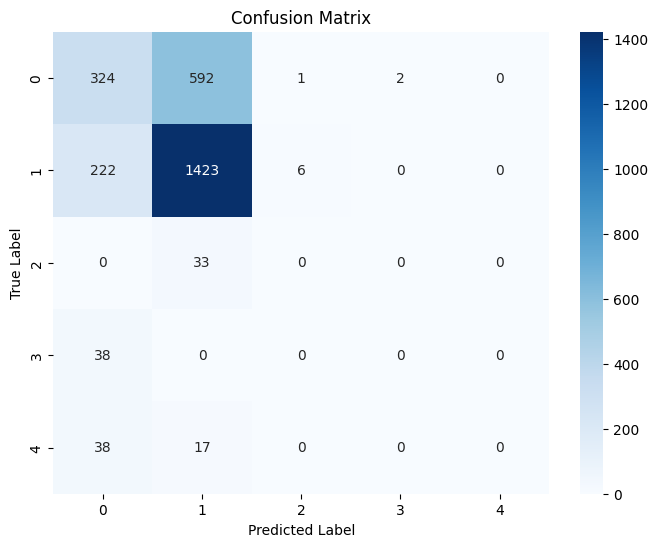

In [62]:
plot_confusion_matrix(y_test,y_pred)

### **Naive Bias**

In [63]:
# Naive Bias
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
y_pred = nb_model.fit(X_train, y_train).predict(X_test)

In [64]:
# Metrics Performance
#print(classification_report(y_test,y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.678511,0.436344,0.531126,919.000000
1,0.903348,0.866142,0.884354,1651.000000
2,1.000000,1.000000,1.000000,33.000000
3,0.301587,1.000000,0.463415,38.000000
4,0.110193,0.727273,0.191388,55.000000
accuracy,0.720326,0.720326,0.720326,0.720326
macro avg,0.598728,0.805952,0.614056,2696.000000
weighted avg,0.803227,0.720326,0.745293,2696.000000


In [65]:
print(confusion_matrix(y_test,y_pred))

[[ 401  152    0   74  292]
 [ 184 1430    0    6   31]
 [   0    0   33    0    0]
 [   0    0    0   38    0]
 [   6    1    0    8   40]]


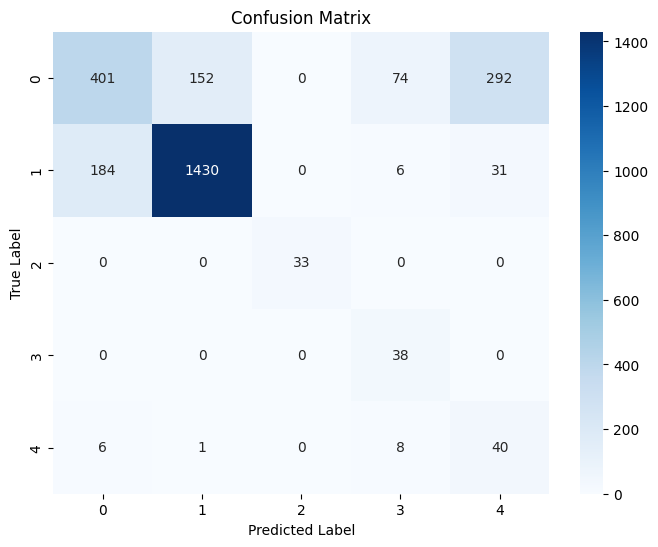

In [66]:
plot_confusion_matrix(y_test,y_pred)

### **Decision Tree**

In [67]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=0)
y_pred = dt_model.fit(X_train, y_train).predict(X_test)

In [68]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

DecisionTreeClassifier()

In [69]:
# Metrics Performance
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.819709,0.796518,0.807947,919.000000
1,0.895558,0.903695,0.899608,1651.000000
2,1.000000,1.000000,1.000000,33.000000
3,1.000000,1.000000,1.000000,38.000000
4,0.787879,0.945455,0.859504,55.000000
accuracy,0.870549,0.870549,0.870549,0.870549
macro avg,0.900629,0.929133,0.913412,2696.000000
weighted avg,0.870257,0.870549,0.870189,2696.000000


In [70]:
print(confusion_matrix(y_test,y_pred))

[[ 732  174    0    0   13]
 [ 158 1492    0    0    1]
 [   0    0   33    0    0]
 [   0    0    0   38    0]
 [   3    0    0    0   52]]


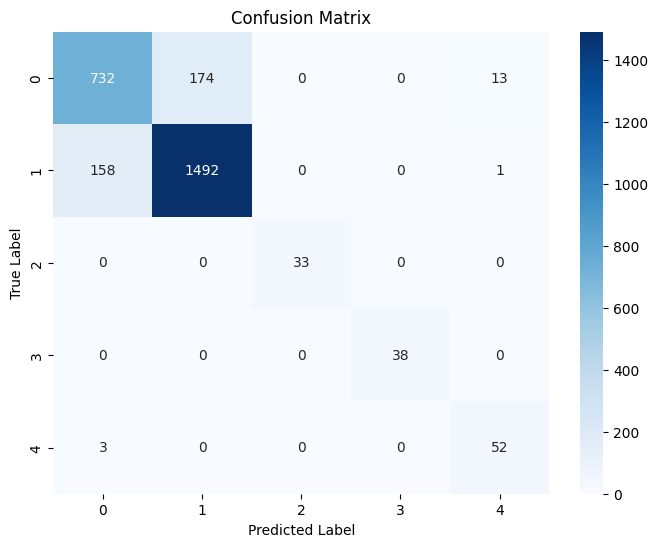

In [71]:
plot_confusion_matrix(y_test,y_pred)

**Interpreting the given confusion matrix:**

- Class 0:
Correctly classified: 706 instances (True positives)
Misclassified as class 1: 177 instances
Misclassified as class 4: 17 instances
- Class 1:
Correctly classified: 1470 instances (True positives)
Misclassified as class 0: 205 instances
Misclassified as class 4: 1 instance
- Class 2:
Correctly classified: 29 instances (True positives)
- Class 3:
Correctly classified: 33 instances (True positives)
- Class 4:
Correctly classified: 51 instances (True positives)
Misclassified as class 0: 7 instances

### Feature Selection

In [72]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, dt_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


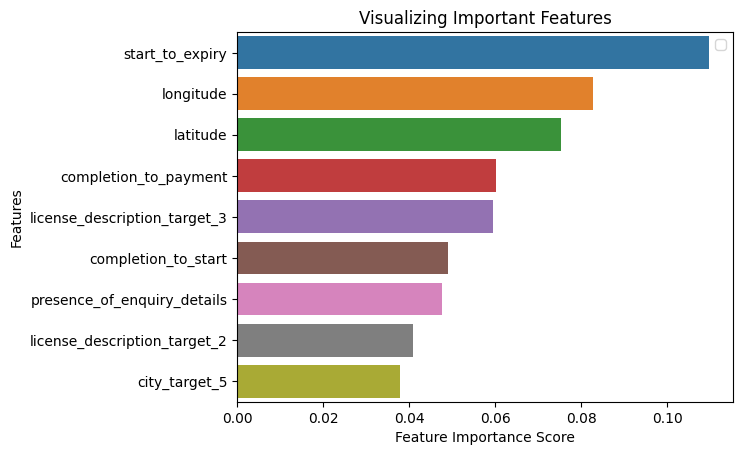

In [73]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Random Forest

In [74]:
# Random Tree
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=1)
y_pred = rf_model.fit(X_train, y_train).predict(X_test)

In [75]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [78]:
#Metrics
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.854664,0.857454,0.856056,919.000000
1,0.924104,0.921866,0.922984,1651.000000
2,1.000000,1.000000,1.000000,33.000000
3,1.000000,1.000000,1.000000,38.000000
4,0.892857,0.909091,0.900901,55.000000
accuracy,0.901706,0.901706,0.901706,0.901706
macro avg,0.934325,0.937682,0.935988,2696.000000
weighted avg,0.901795,0.901706,0.901748,2696.000000


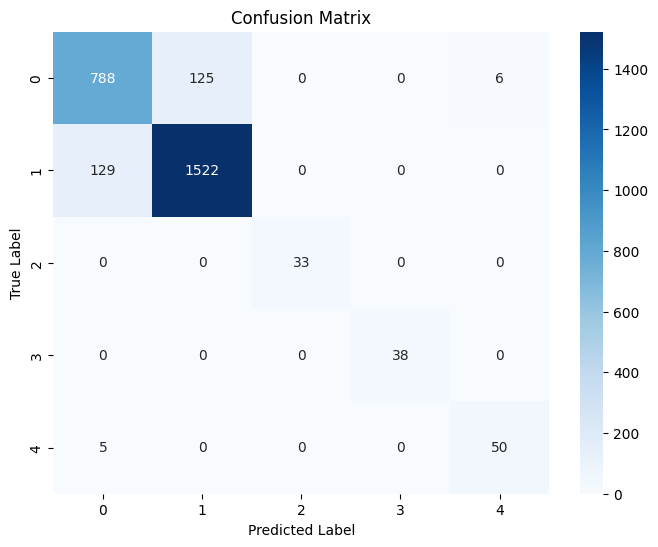

In [79]:
plot_confusion_matrix(y_test,y_pred)

### Feature Importance

In [81]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, rf_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


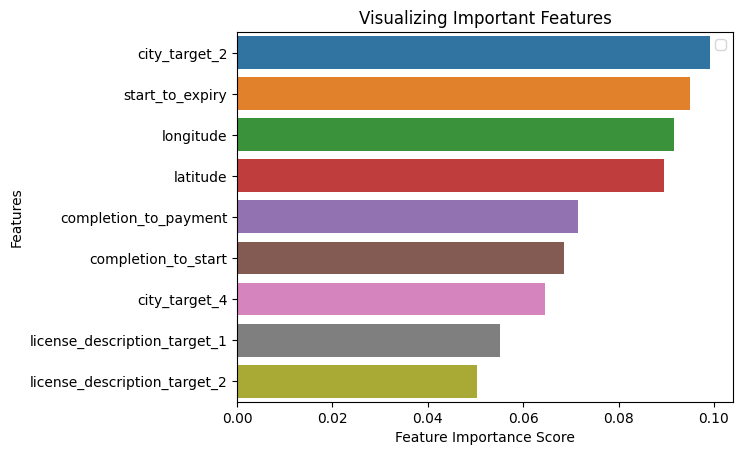

In [82]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Adaboost 

In [83]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(random_state=0)
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=0)

In [84]:
y_pred = ada_model.predict(X_test)

In [86]:
#Metrics
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.697634,0.866159,0.772816,919.000000
1,0.919444,0.801938,0.856681,1651.000000
2,0.550000,1.000000,0.709677,33.000000
3,0.941176,0.421053,0.581818,38.000000
4,0.368421,0.254545,0.301075,55.000000
accuracy,0.809718,0.809718,0.809718,0.809718
macro avg,0.695335,0.668739,0.644413,2696.000000
weighted avg,0.828378,0.809718,0.811085,2696.000000


## XGBoost

In [88]:
# xg Boost
from xgboost import XGBClassifier

In [89]:
xg_model = XGBClassifier(random_state=1)
xg_model.fit(X_train, y_train)

[22:42:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
y_pred = xg_model.predict(X_test)

In [91]:
from sklearn import metrics
metrics.f1_score(y_test,y_pred,average="macro")

0.9415889436778354

In [92]:
#Metrics
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.868363,0.854189,0.861218,919.000000
1,0.923031,0.929740,0.926373,1651.000000
2,1.000000,1.000000,1.000000,33.000000
3,1.000000,1.000000,1.000000,38.000000
4,0.896552,0.945455,0.920354,55.000000
accuracy,0.906157,0.906157,0.906157,0.906157
macro avg,0.937589,0.945877,0.941589,2696.000000
weighted avg,0.905883,0.906157,0.905979,2696.000000


### Feature Importance

In [94]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, xg_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


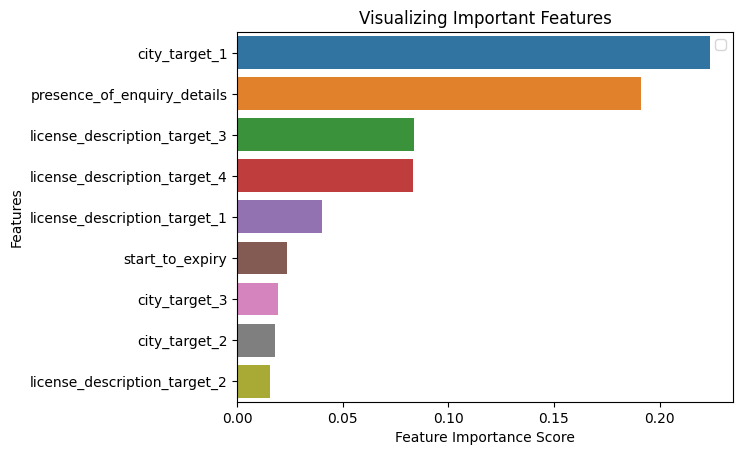

In [95]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## **Hyperparameter Tuning**
### Tree parameters
1. No. of trees
2. Depth of the trees
3. Min no. of samples in the leaf node
4. Max number of features
5. Split Criterion 

### **RandomSearchCV**

In [96]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [97]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,10]

In [99]:
n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf

([200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 ['auto', 'sqrt'],
 [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 [2, 5, 10, 15, 20],
 [1, 2, 4, 6, 10])

In [98]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_leaf':[1]
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [1]}


In [100]:
rf_random = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = random_grid, n_iter = 10, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

In [101]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/DanyTQ/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanyTQ/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/DanyTQ/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also t

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [106]:
best_params_ = rf_random.best_params_

In [107]:
rf_model_tuned = RandomForestClassifier(**best_params_)

In [108]:
rf_model_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=1400)

In [109]:
y_pred = rf_model_tuned.predict(X_test)

In [110]:
#Metrics
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.858849,0.860718,0.859783,919.000000
1,0.926667,0.926105,0.926386,1651.000000
2,1.000000,1.000000,1.000000,33.000000
3,1.000000,1.000000,1.000000,38.000000
4,0.870370,0.854545,0.862385,55.000000
accuracy,0.904303,0.904303,0.904303,0.904303
macro avg,0.931177,0.928274,0.929711,2696.000000
weighted avg,0.904332,0.904303,0.904316,2696.000000


### **GridSearchCV**

In [111]:
from sklearn.model_selection import GridSearchCV

In [112]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50,100,150,None],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2,4,5,6],
    'n_estimators': [50,100,150,200]
}

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [115]:
%time grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
CPU times: user 7.76 s, sys: 715 ms, total: 8.48 s
Wall time: 18min 50s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150, None],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [116]:
grid_search.best_params_

{'max_depth': 50,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [117]:
rf_grid_tuned = RandomForestClassifier(**grid_search.best_params_)

In [118]:
rf_grid_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=3, n_estimators=150)

In [119]:
y_pred = rf_grid_tuned.predict(X_test)

In [120]:
#Metrics
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.851613,0.861806,0.856679,919.000000
1,0.926533,0.924288,0.925409,1651.000000
2,1.000000,1.000000,1.000000,33.000000
3,1.000000,1.000000,1.000000,38.000000
4,0.833333,0.727273,0.776699,55.000000
accuracy,0.900964,0.900964,0.900964,0.900964
macro avg,0.922296,0.902673,0.911758,2696.000000
weighted avg,0.901028,0.900964,0.900912,2696.000000


### **Hypertuning using Hyperopt/Bayesian optimization**

In [123]:
from hyperopt import hp,fmin,tpe,Trials

In [124]:
# Create the parameter grid based on the results of random search 
param_grid_space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }

In [125]:
def optimize(param_grid_space):
    X_train,y_train,X_test,y_test
    xgbm = XGBClassifier(n_estimators =param_grid_space['n_estimators'], max_depth = int(param_grid_space['max_depth']),
                         gamma = param_grid_space['gamma']
                        )
    xgbm.fit(X_train, y_train)
    y_pred = xgbm.predict(X_test)
    f1score = metrics.f1_score(y_test,y_pred,average="macro")
    return -1*f1score

In [126]:
trial = Trials()
result = fmin(fn=optimize,space=param_grid_space,max_evals=3,trials=trial,algo=tpe.suggest)

[00:16:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:17:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
100%|██████████| 3/3 [01:31<00:00, 30.54s/trial, best loss: -0.9292886918154781]


In [127]:
print(result)

{'colsample_bytree': 0.6538518337770194, 'gamma': 1.6860186251616334, 'max_depth': 16.0, 'min_child_weight': 8.0, 'reg_alpha': 134.0, 'reg_lambda': 0.4913688646293465}


In [128]:
result["max_depth"] = int(result["max_depth"])

In [129]:
xg_model = XGBClassifier(**result)
xg_model.fit(X_train, y_train)

[00:18:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6538518337770194,
              gamma=1.6860186251616334, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=16, min_child_weight=8.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=134.0, reg_lambda=0.4913688646293465,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [130]:
y_pred = xg_model.predict(X_test)

In [131]:
#Metrics
report = classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()

# Print or further manipulate the DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.795455,0.837867,0.816110,919.00000
1,0.910736,0.914597,0.912662,1651.00000
2,1.000000,1.000000,1.000000,33.00000
3,1.000000,0.605263,0.754098,38.00000
4,0.857143,0.218182,0.347826,55.00000
accuracy,0.870920,0.870920,0.870920,0.87092
macro avg,0.912667,0.715182,0.766139,2696.00000
weighted avg,0.872697,0.870920,0.867061,2696.00000
